In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
import lightcones.linalg as ll

In [18]:
class limiting_recursion:
    def __init__(self, dt, t_past, t_future, n_rel, n_iter, M_func=None, M_table=None):
        self.dt = dt
        self.n_t_past = int(t_past / dt)
        self.n_t_future = int(t_future / dt)
        self.t_max = t_past + t_future
        self.t = np.arange(0, self.t_max, dt)
        self.n_t_max = len(self.t)

        self.M = np.zeros(self.n_t_max)
        for i in range(self.n_t_max):
            if M_func is not None:
                self.M[i] = M_func(i * dt)
            if M_table is not None:
                self.M[i] = M_table[i]
    
        self.n_rel = n_rel
        self.n_iter = n_iter

    def apply_memory_matrix(self, x):
        x_out = np.zeros(self.n_t_past)
        for i in range(self.n_t_future):
            m = self.M[i:i+self.n_t_past]
            x_out = x_out + np.vdot(m, x) * m
        return x_out
    
    def get_memory_matrix(self):
        memory_matrix = sparse.linalg.LinearOperator((self.n_t_past, self.n_t_past), matvec=self.apply_memory_matrix)
        return memory_matrix
    
    def ensure_phase(self, eigenvectors):
        eigenvectors_corrected = eigenvectors.copy()
    
        for i in range(eigenvectors.shape[1]):
            v = eigenvectors[:, i]
            idx_max = np.argmax(np.abs(v))
        
            if v[idx_max] < 0:
                eigenvectors_corrected[:, i] = -v         

        return eigenvectors_corrected
    
    def get_relevant_modes(self):
        pi, v = eigsh(self.get_memory_matrix(), k=self.n_rel, which='LM')
        v = self.ensure_phase(v)
        return pi, v
    
    def compute_limiting_recursion(self):
        v_in = np.zeros(self.n_t_past)
        v_in[0] = 1

        memory_matrix = self.get_memory_matrix()
        pi, v = self.get_relevant_modes()

        def iterate(v):
            v_shifted = np.vstack((np.zeros(self.n_rel), v[:-1, :]))
            U = np.column_stack((v_in, v_shifted))
            rho = U.T.conj() @ (memory_matrix @ U)
            pi_, U_ = ll.find_eigs_descending(rho)
            U_ = self.ensure_phase(U_)
            v_ = U @ U_
            return pi_, U_, v_ 
        
        pi_lst = []
        U_lst = []
        v_lst = []

        v_ = np.copy(v)

        for i in range(self.n_iter):
            pi_, U_, v_ = iterate(v_)
            pi_lst.append(pi_)
            U_lst.append(U_)
            v_lst.append(v_)
            v_ = np.copy(v_)
            v_ = v_[:,:-1]

        self.pi = pi
        self.v = v

        self.pi_lst = pi_lst
        self.U_lst = U_lst
        self.v_lst = v_lst

        self.M_recursion = v_.T @ self.M[:self.n_t_past]  
        self.v_recusion = v_
        self.U_recursion = U_        

In [19]:
epsilon = 0.1
dt = 0.01
t_past = 40
t_future = 40 
n_iter = 1000
n_rel = 10

def M(t):
    return epsilon / (epsilon**2 + t**2)

In [20]:
recursion = limiting_recursion(dt, t_past, t_future, n_rel, n_iter, M_func=M)
recursion.compute_limiting_recursion()

In [21]:
def ode_midpoint(dt, RHS, initial_state, start_time = None, start_index = None, end_time = None, end_index = None, tol = 10**(-6)):

    K = initial_state.size

    use_time = False
    use_index = False

    if not start_time is None and not end_time is None:

        use_time = True
        nt = math.floor((end_time - start_time) / dt)

    if not start_index is None and not end_index is None:

        use_index = True
        nt = end_index - start_index

    if not use_index != use_time:
        raise ValueError('evolution should be called either in time or in step-index mode')


    if (use_index):
        yield (start_index, initial_state)
    else:
        yield (start_time, initial_state)

    psi = np.copy(initial_state)
    psi_mid = np.copy(psi)

    b = nt - 1

    for i in range(0, b):

        psi_mid[:] = psi

        if (use_index):
            
            time_moment = start_index + i
            
        else:
            
            time_moment = start_time + (i + 0.5) * dt
            
        while(True):

            psi_mid_next = RHS(time_moment, psi_mid)

            psi_mid_next = psi + dt / 2 * psi_mid_next

            err = max(abs(psi_mid_next - psi_mid))

            swp = psi_mid_next
            psi_mid_next = psi_mid
            psi_mid = swp

            if err < tol:
                break

        psi = 2 * psi_mid - psi

        if (use_index):
            yield (start_index + i + 1, psi)
        else:
            yield (start_time + i * dt, psi)

In [22]:
xi = np.random.normal(size=recursion.n_t_max) / math.sqrt(dt)

In [23]:
M_ = np.zeros(recursion.n_t_max) 
for i in range(recursion.n_t_max):
    M_[i] = epsilon / (epsilon**2 + (recursion.t[i] - recursion.t[0])**2) * dt

In [24]:
p0 = np.array([0])

p_trajectory = []
t_axis = []

def RHS(ti, p_mid):
    n_memory = len(p_trajectory)
    rhs = -sum(M_[:n_memory+1] * ([p_mid[0]] + p_trajectory[::-1])) + (xi[ti] + xi[ti + 1]) / 2
    return rhs

for ti, p in ode_midpoint(dt, RHS, p0, start_index = 0, end_index = recursion.n_t_max - 1):
    p_trajectory.append(p[0])
    t_axis.append(ti * dt)

In [25]:
v_state = np.zeros(n_rel)
p_trajectory_ = [0]

for i in range(1, recursion.n_t_max):
    v_in = (xi[i] - np.vdot(recursion.M_recursion * dt, v_state)) * dt + p_trajectory_[i-1] 
    v_ = np.concatenate([[v_in], v_state])
    v_ = recursion.U_recursion.T.conj() @ v_
    v_state = v_[:-1]
    p_trajectory_.append(v_in)

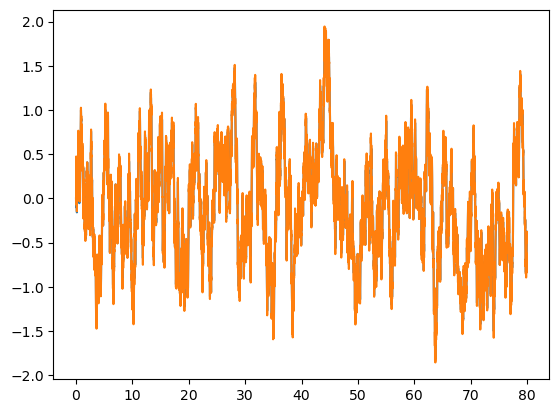

In [26]:
plt.plot(t_axis, p_trajectory)
plt.plot(t_axis, p_trajectory_[:-1])

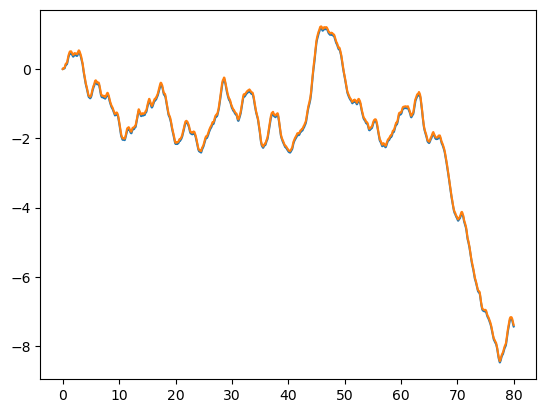

In [27]:
x_trajectory = [0]
for i in range(1, len(p_trajectory)):
    x = x_trajectory[i-1] + p_trajectory[i] * dt
    x_trajectory.append(x)

x_trajectory_ = [0]
for i in range(1, len(p_trajectory_[:-1])):
    x = x_trajectory_[i-1] + p_trajectory_[i] * dt
    x_trajectory_.append(x)

plt.plot(t_axis, x_trajectory)
plt.plot(t_axis, x_trajectory_)